## LSM for Heston Model

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

class Heston:

#S0 = 156.91  # initial stock price
#r = 0.0023  # risk-free rate
#T = 0.528  # time to maturity
#kappa = 1.5  # mean reversion speed
#theta = 0.04  # long-run variance
#sigma = 0.2994  # implied volatility
#rho = -0.3  # correlation between the stock price and volatility
#V0 = sigma**2  # initial variance
#K = 165.0  # strike price
#N = 1000  # number of simulation paths
#M = 1  # number of time steps
#dt = T / M  # time step size
    
    def __init__(self,
                 sigma = 0.2,
                 theta = 0.04,
                 kappa = 1.5,
                 rho = -0.3,
                 T1=1, 
                 T2=2, 
                 K=1.10):
        
        self.spot = 1
        self.sigma = sigma
        self.theta = theta
        self.kappa = kappa
        self.rho = rho
        self.T1 = T1
        self.T2 = T2
        self.K = K
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2]) # Draws from standard normal
        print(returns.shape)
        # correlated vol
        z1 = self.rho * returns[:,0] + np.sqrt(1 - self.rho ** 2) * returns[:,0]
        print(z1.shape)
        z2 = self.rho * returns[:,1] + np.sqrt(1 - self.rho ** 2) * returns[:,1]
        print(z2.shape)

        # SDE

        vol0 = self.sigma*self.sigma
        R1 = np.exp(-0.5*vol0*self.T1 + self.sigma*np.sqrt(self.T1)*returns[:,0]) # asset price return period 1
        print(R1.shape)
        V1 = np.maximum(
            0.0, vol0 + self.kappa * (self.theta - vol0) * (self.T1) + self.sigma * np.sqrt(vol0) * np.sqrt(self.T1) * z1
        )
        print(V1.shape)
        R2 = np.exp(-0.5*V1*(self.T2-self.T1) + np.sqrt(V1)*np.sqrt(self.T2-self.T1)*returns[:,1]) # asset price return period 2 with different volatility
        print(R2)
        print(R2.shape)
        V2 = np.maximum(
            0.0, V1 + self.kappa * (self.theta - V1) * (self.T2 - self.T1) + self.sigma * np.sqrt(V1) * np.sqrt(self.T2 - self.T1) * z2
        )
        S1 = self.spot * R1 # spot * return gives asset price in period 1
        print(S1)
        print(S1.shape)
        S2 = S1 * R2 # gives asset price in period 2
        print(S2.shape)
        # payoff
        pay = np.maximum(0, S2 - self.K) # compute payoff 
        print(pay.shape)
        X = S1 # this is our input (asset price) note we're only looking at S1 not S2
        Y = pay # this is our output (the payoff)
        print(Y.shape)
            
        # differentials - note that we are just looking at one time period
        # note that this is just the delta 
        Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) # the differential is zero is price less than strike
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])

In [43]:
c = Heston()

asset_prices, payoffs, differentials = c.trainingSet(m = 10000)
#payoffs


(10000, 2)
(10000,)
(10000,)
(10000,)
(10000,)
[0.71978441 0.98906862 0.6966952  ... 1.1221518  1.41244154 0.8440633 ]
(10000,)
[1.20973683 1.02905324 0.99305619 ... 0.95859278 1.04405669 1.23927091]
(10000,)
(10000,)
(10000,)
(10000,)


Text(0.5, 1.0, 'Simulated data')

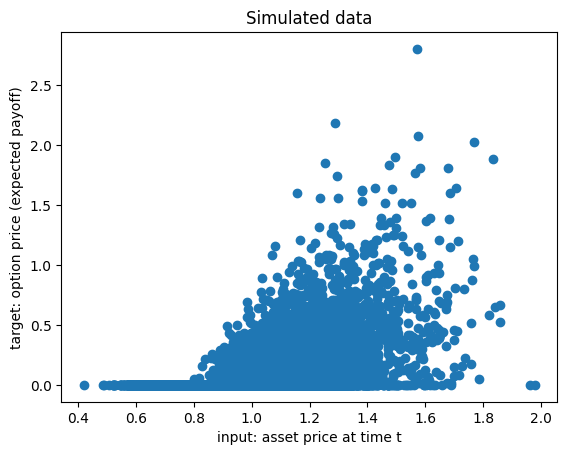

In [44]:
plt.scatter(x = asset_prices, y = payoffs)
plt.ylabel('target: option price (expected payoff)')
plt.xlabel('input: asset price at time t')
plt.title('Simulated data')

In [3]:
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        print(vol0)
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)

            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas   

In [ ]:
class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0

        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape(-1,1), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        np.random.seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * np.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = np.random.uniform(low=adj_lower, high = adj_upper, size=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    